In [6]:
from model_staging import create_cnn2D, fetch_images_dataframe
from skopt.space import Real, Integer
from skopt.utils import use_named_args
from skopt import gp_minimize
from keras.layers import Conv2D, MaxPooling2D, Dropout, GlobalAveragePooling2D, Dense
import keras
from keras import backend as K
import pandas as pd
import numpy as np

In [7]:
train_df = pd.read_csv("train_df.csv")
test_df = pd.read_csv("test_df.csv")

In [8]:
batch_size = 24
target_size = (64,64)
train_path = "C://Users//Alec//MyPython//Beatles/train_melspec"
test_path = "C://Users//Alec//MyPython//Beatles/test_melspec"

In [9]:
train_gen, valid_gen = fetch_images_dataframe(train_df, x_col="song", y_col="artist", directory=train_path,
                                                           batch_size=batch_size, target_size=target_size, 
                                                            class_mode="categorical", shuffle=True, seed=1, 
                                                            validation_split=0.2, save_format="png")

Found 601 validated image filenames belonging to 4 classes.
Found 150 validated image filenames belonging to 4 classes.


In [10]:
learning_rate = Real(low=1e-5, high=1.0, prior='log-uniform', name='learning_rate')
epochs = Integer(low=20, high=100, name="epochs")
input_shape = (None, 64, 64, 3)
classes = 4
steps_per_epoch = np.ceil(train_gen.samples/batch_size)
validation_steps = np.ceil(valid_gen.samples/batch_size)

In [11]:
learning_rate

Real(low=1e-05, high=1.0, prior='log-uniform', transform='identity')

In [12]:
1e-4

0.0001

In [13]:
dimensions = [learning_rate, epochs]
default_parameters = [0.00001, 20]

In [14]:
best_accuracy = 0.0

In [15]:
best_model = "models/melspec/skopt_best_adam.h5"

In [16]:
@use_named_args(dimensions)
def fitness(learning_rate, epochs):
    global input_shape, classes

    # print the hyperparameters
    print('learning rate: {0:.1e}'.format(learning_rate))
    print('epochs       : {0}'.format(epochs))

    model = create_cnn2D(input_shape, classes, learning_rate=learning_rate, optimizer="Adam")
    
    global train_gen, valid_gen, steps_per_epoch, validation_steps
    class_weights = [0.25, 0.25, 0.25, 0.25]
    history = model.fit_generator(train_gen, validation_data=valid_gen, steps_per_epoch=steps_per_epoch,
                                validation_steps=validation_steps, epochs=epochs, class_weight=class_weights)
    
    accuracy = history.history['val_accuracy'][-1]
    print("\nModel accuracy: {0:.2%}\n".format(accuracy))
    
    
    global best_accuracy
    if accuracy > best_accuracy:
        model.save(best_model)
        
        
        best_accuracy = accuracy
    
    del model
    
    K.clear_session()
    
    return -accuracy

In [17]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_visible_devices(gpus[0], 'GPU')

In [18]:
import os
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [19]:
search_result = gp_minimize(func=fitness,
                                dimensions=dimensions,
                                acq_func='EI', # Expected Improvement.
                                n_calls=12,
                                x0=default_parameters,
                                random_state=1)

learning rate: 1.0e-05
epochs       : 20
Epoch 1/20
26/26 [==============================] - 6s 245ms/step - loss: 1.3185 - accuracy: 0.3428 - val_loss: 1.3327 - val_accuracy: 0.3667
Epoch 2/20
26/26 [==============================] - 2s 73ms/step - loss: 1.3093 - accuracy: 0.3960 - val_loss: 1.2754 - val_accuracy: 0.3667
Epoch 3/20
26/26 [==============================] - 2s 78ms/step - loss: 1.2872 - accuracy: 0.3960 - val_loss: 1.3350 - val_accuracy: 0.3667
Epoch 4/20
26/26 [==============================] - 2s 80ms/step - loss: 1.3027 - accuracy: 0.3993 - val_loss: 1.3893 - val_accuracy: 0.4333
Epoch 5/20
26/26 [==============================] - 2s 85ms/step - loss: 1.2768 - accuracy: 0.3943 - val_loss: 1.2848 - val_accuracy: 0.3667
Epoch 6/20
26/26 [==============================] - 2s 86ms/step - loss: 1.2488 - accuracy: 0.3960 - val_loss: 1.4071 - val_accuracy: 0.3733
Epoch 7/20
26/26 [==============================] - 2s 84ms/step - loss: 1.2431 - accuracy: 0.3993 - val_loss: 1

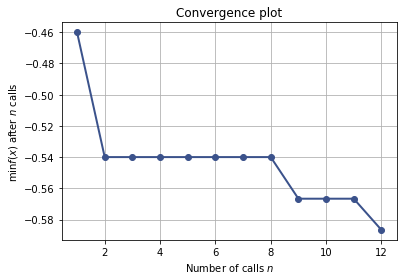

In [20]:
from skopt.plots import plot_convergence, plot_objective, plot_evaluations
plot_convergence(search_result)

In [21]:
# fig = plot_objective_2D(result=search_result,
#                         dimension_name1='learning_rate',
#                         dimension_name2='epochs',
#                         levels=50)

In [22]:
dim_names = ["learning_rate", "epochs"]

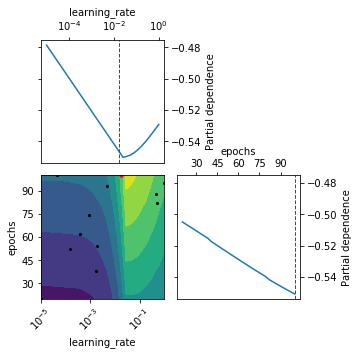

In [23]:
fig, ax = plot_objective(result=search_result)

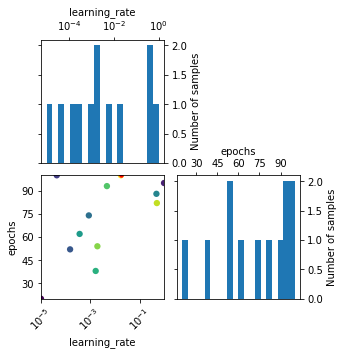

In [24]:
fig, ax = plot_evaluations(result=search_result)

In [25]:
search_result.x

[0.01733304007508762, 100]

In [26]:
space = search_result.space

In [27]:
sorted(zip(search_result.func_vals, search_result.x_iters))

[(-0.5866666436195374, [0.01733304007508762, 100]),
 (-0.5666666626930237, [0.004699693600285314, 93]),
 (-0.5533333420753479, [0.4961796485117123, 82]),
 (-0.5400000214576721, [0.00036844068804921996, 62]),
 (-0.5400000214576721, [0.0019320752621429876, 54]),
 (-0.5400000214576721, [0.47609690039378916, 88]),
 (-0.5400000214576721, [0.9681085478045705, 95]),
 (-0.5333333611488342, [0.0008700690210600545, 74]),
 (-0.5133333206176758, [4.371417028022744e-05, 100]),
 (-0.5133333206176758, [0.0016491663656852536, 38]),
 (-0.5066666603088379, [0.000151511251231029, 52]),
 (-0.46000000834465027, [1e-05, 20])]

In [28]:
best_model_adam = keras.models.load_model(best_model)
type(best_model_adam)

keras.engine.sequential.Sequential

In [29]:
test_gen = fetch_images_dataframe(test_df, x_col="song", y_col="artist", directory=test_path,
                                                           batch_size=batch_size, target_size=target_size, 
                                                            class_mode="categorical", shuffle=False, seed=1, save_format="png")

Found 216 validated image filenames belonging to 1 classes.


In [30]:
probabilities = best_model_adam.predict_generator(test_gen)

In [31]:
preds = np.argmax(probabilities, axis=1)

In [32]:
class_map = train_gen.class_indices

In [33]:
pred_df = pd.DataFrame(data={"songs": test_gen.filenames,
                                   "predictions": preds})

In [34]:
mapping = {v:k for k,v in class_map.items()}

In [35]:
pred_df["predictions"] = pred_df["predictions"].map(mapping)

In [36]:
pred_df

,songs,predictions
0,Rock And Roll Music (Remastered 2009)-IRF6nmqc...,starr
1,Good Morning Good Morning (Remastered 2009)-sj...,Lennon
2,You Never Give Me Your Money (2019 Mix)-W8uZje...,mccartney
3,Being For The Benefit Of Mr. Kite! (Remastered...,starr
4,Mr Moonlight (Remastered 2009)-FZQ8nWZJrhA.png,Lennon
...,...,...
211,Pepperland Laid Waste (Remastered 2009)-JGauvW...,mccartney
212,Think For Yourself (Remastered 2009)-vtx5NTxeb...,starr
213,You Can't Do That (Remastered 2009)-6PK21u7Yzm...,starr
214,Glass Onion (Remastered 2009)-2tSIZLuCKUI.png,Lennon


In [37]:
pred_df.groupby("predictions").count()

,songs
predictions,
Lennon,55
harrison,24
mccartney,105
starr,32


In [38]:
pred_df = pred_df.merge(test_df[["album", "song"]], left_on="songs",right_on="song")
pred_df.drop("song", axis=1, inplace=True)

In [39]:
pred_df.groupby(["album", "predictions"]).count()

songs
album              predictions       
AbbeyRoad          Lennon           8
                   harrison         1
                   mccartney       25
                   starr            6
BeatlesForSale     Lennon           4
                   harrison         4
                   mccartney        3
                   starr            3
HardDaysNight      Lennon           4
                   harrison         2
                   mccartney        6
                   starr            1
Help!              Lennon           3
                   harrison         4
                   mccartney        7
LetItBe            Lennon           2
                   harrison         3
                   mccartney        4
                   starr            3
MagicalMysteryTour Lennon           5
                   harrison         1
                   mccartney        4
                   starr            1
PleasePleaseMe     Lennon           5
                   harrison         1
                   mccartney        5
                   starr            3
Revolver           Lennon           6
                   harrison         3
                   mccartney        4
                   starr            1
RubberSoul         harrison         1
                   mccartney       10
                   starr            3
SgtPepper          Lennon           3
                   mccartney        8
                   starr            2
WhiteAlbum         Lennon           8
                   harrison         1
                   mccartney       18
                   starr            3
WithTheBeatles     Lennon           2
                   harrison         3
                   mccartney        5
                   starr            4
YellowSubmarine    Lennon           5
                   mccartney        6
                   starr            2